## Analysis of the experiments for Our Approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as Rect
import seaborn as sns
import json

from matplotlib.pyplot import style

from matplotlib.patches import Rectangle
from scipy.stats import mannwhitneyu

from cliffs_delta import cliffs_delta

from constants import *

from pathlib import Path

### Load similarity scores from results directory

In [2]:
path_results = Path("./results/bg_0001/")

results = {}

for exp in path_results.glob("*"):
    if "." in exp.name:
        continue
        
    exp_results = {}
    
    for run in exp.glob("*"):
        if "." in run.name:
            continue
        run_results = {}
        
        for ss in run.glob("*.csv"):
            pth = path_results / exp.name / run.name / ss.name
            run_results[ss.stem] = pd.read_csv(pth, index_col=0)
            
        exp_results[run.name] = run_results
    
    results[exp.name] = exp_results

In [3]:
(df := pd.concat({k1: pd.concat({k2: pd.concat({k3: v3 for k3, v3 in v2.items()}, axis=0) for k2, v2 in v1.items()}, axis=0) for k1, v1 in results.items()}, axis=0))

object_key  \
exp_0            c 1 27  {"bbox": [941, 320, 1280, 720], "tbox": [0, 0,...   
                     26  {"bbox": [799, 523, 989, 713], "tbox": [0, 0, ...   
                     25  {"bbox": [1085, 565, 1275, 755], "tbox": [380,...   
                     24  {"bbox": [1085, 565, 1275, 755], "tbox": [380,...   
                     23  {"bbox": [1085, 565, 1275, 755], "tbox": [380,...   
...                                                                    ...   
exp_appearance_4 j 5 5   {"bbox": [0, 0, 1280, 720], "tbox": [0, 0, 128...   
                     4   {"bbox": [0, 0, 1280, 720], "tbox": [0, 0, 128...   
                     3   {"bbox": [0, 0, 1280, 720], "tbox": [0, 0, 128...   
                     2   {"bbox": [0, 0, 1280, 720], "tbox": [0, 0, 128...   
                     1   {"bbox": [0, 0, 1280, 720], "tbox": [0, 0, 128...   

                         cosine_similarity  pixel_similarity  \
exp_0            c 1 27                1.0          1.000000   
                     26                1.0          1.000000   
                     25                1.0          1.000000   
                     24                1.0          1.000000   
                     23                1.0          1.000000   
...                                    ...               ...   
exp_appearance_4 j 5 5                 1.0          0.999911   
                     4                 1.0          1.000000   
                     3                 1.0          1.000000   
                     2                 1.0          1.000000   
                     1                 1.0          0.999969   

                         mean_squared_error  structural_similarity  
exp_0            c 1 27            0.000000                    1.0  
                     26            0.000000                    1.0  
                     25            0.000000                    1.0  
                     24            0.000000                    1.0  
                     23            0.000000                    1.0  
...                                     ...                    ...  
exp_appearance_4 j 5 5             0.000089                    1.0  
                     4             0.000000                    1.0  
                     3             0.000000                    1.0  
                     2             0.000000                    1.0  
                     1             0.000031                    1.0  

[56980 rows x 5 columns]

In [4]:
df.sort_index(inplace=True)

### Automatically set thresholds

In [5]:
thresholds = df.drop("object_key", axis=1).loc["exp_0"].min()
thresholds["mean_squared_error"] = df.loc["exp_0"]["mean_squared_error"].max()
thresholds

cosine_similarity        0.999861
pixel_similarity         0.966510
mean_squared_error       0.033490
structural_similarity    0.999878
dtype: float64

### Plot distributions of buggy samples and okay samples, per metric

In [6]:
def convert_desc_to_key(desc):
    desc_json = json.loads(desc)
    del desc_json["bbox"]
    del desc_json["angle"]
    del desc_json["tile"]
    del desc_json["scaleMode"]
    desc_clean = json.dumps(desc_json)
    return DESCRIPTION_TO_KEY[desc_clean]

df_findbugs = df.copy().reset_index()
df_findbugs["key"] = df_findbugs["object_key"].apply(convert_desc_to_key)
df_findbugs = df_findbugs.rename({
    "level_0": "exp",
    "level_1": "run",
    "level_2": "snapshot",
    "level_3": "layer",
}, axis=1)

In [7]:
def check_key(key, exp):
    if key not in BUGS:
        return False
    return (exp in BUGS[key])

df_findbugs["okay"] = df_findbugs["exp"] == "exp_0"
df_findbugs["buggy"] = (df_findbugs["exp"] != "exp_0") & df_findbugs.apply(lambda x: check_key(x["key"], x["exp"]), axis=1)

#sanity check
(df_findbugs["okay"] & df_findbugs["buggy"]).any()

False

In [8]:
df_plotbugs = df_findbugs[df_findbugs["okay"] | df_findbugs["buggy"]].copy()
df_plotbugs["class"] = df_plotbugs["okay"].apply(lambda x: "okay" if x else "buggy")
df_plotbugs = df_plotbugs.drop(["object_key", "layer", "buggy", "okay"], axis=1)

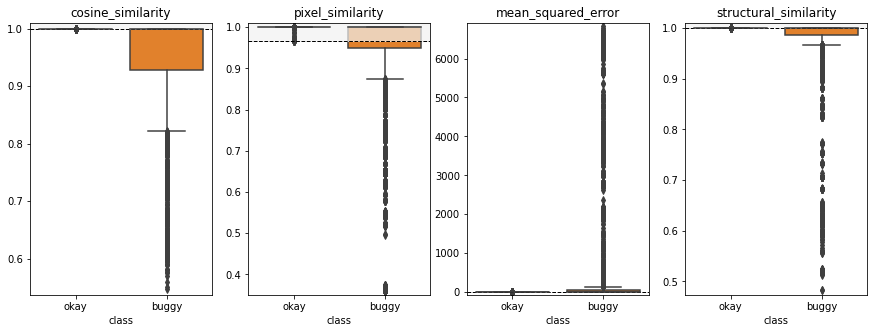

In [9]:
fig, axes = plt.subplots(1,4, figsize=(15,5))

n = df_plotbugs["exp"].nunique()

for i, (ax, metric) in enumerate(zip(axes, df.drop("object_key", axis=1).columns)):
    sns.boxplot(data=df_plotbugs, x="class", y=metric, ax=ax)#, orient="h")#, hue="exp")
    
    scale_val = 0.01*df_plotbugs[metric].max()
    
    if metric == "mean_squared_error":
        th = df.loc["exp_0", metric].max()
        height = -th - scale_val
    else:
        th = df.loc["exp_0", metric].min()
        height = 1 - th + scale_val
    
    ax.hlines(th, -0.5, 1.5, ls="--", color="black", lw=1)
    ax.add_patch(Rect((-0.5, th), width=2, height=height+scale_val, alpha=0.7, color=(0.95, 0.95, 0.95)))
    ax.set_ylabel("")
    ax.set_ylim(df_plotbugs[metric].min() - scale_val, df_plotbugs[metric].max() + scale_val)
    ax.set_title(metric)
        
fig.show()

### Mega plot - baseline + our approach

In [10]:
(baseline_sims := pd.read_csv("./results/baseline_sims.csv", index_col=0))

,exp,run,snapshot,pixel_similarity,structural_similarity,mean_squared_error,class
0,baseline_exp_0,a,0,1.000000,1.000000,0.000000,okay
1,baseline_exp_0,a,1,1.000000,1.000000,0.000000,okay
2,baseline_exp_0,a,2,1.000000,1.000000,0.000000,okay
3,baseline_exp_0,a,3,1.000000,1.000000,0.000000,okay
4,baseline_exp_0,a,4,1.000000,1.000000,0.000000,okay
...,...,...,...,...,...,...,...
2495,baseline_exp_state_6,j,5,0.916150,0.943560,634.094992,buggy
2496,baseline_exp_state_6,j,6,0.911359,0.939670,727.418425,buggy
2497,baseline_exp_state_6,j,7,0.918947,0.943345,587.891923,buggy
2498,baseline_exp_state_6,j,8,0.908812,0.936268,702.819196,buggy


In [11]:
baseline_sims["approach"] = "baseline"
df_plotbugs["approach"] = "ours"

sims = pd.concat([df_plotbugs, baseline_sims], axis=0)#.sort_values(by="approach")

In [12]:
METRIC_TO_KEY_NAME = {
    "pixel_similarity": "PCT",
    "mean_squared_error": "MSE",
    "structural_similarity": "SSIM",
    "cosine_similarity": "ESIM",
}

In [13]:
sims = sims.sort_values(["approach", "exp", "run", "snapshot"])

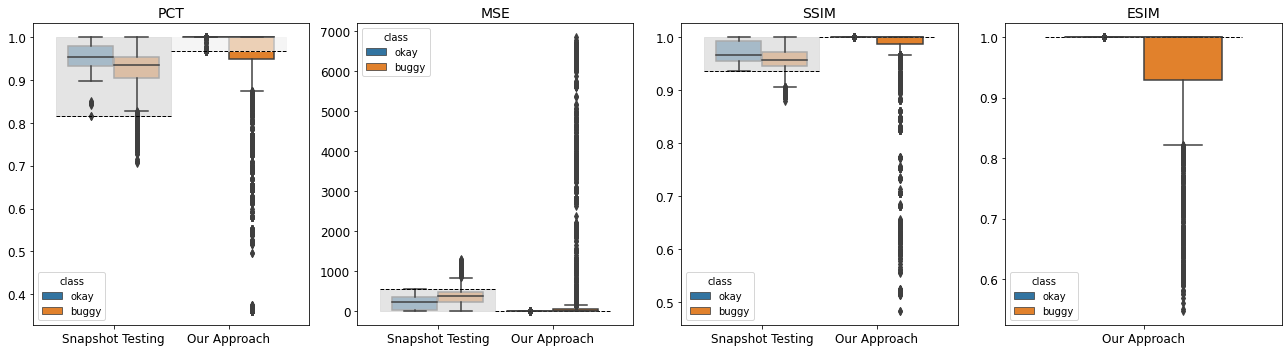

In [14]:
fig = plt.figure(figsize=(18, 5))
axes = fig.subplots(1, 4)

for ax, metric in zip(axes, METRIC_TO_KEY_NAME.keys()):
    sns.boxplot(data=sims, y=metric, x="approach", hue="class", ax=ax)
    scale_val = 0# 0.01*df_plotbugs[metric].max() 
    if metric == "mean_squared_error":
        th_ours = df.loc["exp_0", metric].max()
        h_ours = -th_ours - scale_val
        th_base = baseline_sims[baseline_sims["exp"]=="baseline_exp_0"][metric].max()
        h_base = -th_base - scale_val
    else:
        th_ours = df.loc["exp_0", metric].min()
        h_ours = 1 - th_ours + scale_val
        if metric != "cosine_similarity":
            th_base = baseline_sims[baseline_sims["exp"]=="baseline_exp_0"][metric].min()
            h_base = 1 - th_base + scale_val

    ax.hlines(th_ours, 0.5, 1.5, ls="--", color="black", lw=1)
    ax.add_patch(Rect((0.5, th_ours), width=1, height=h_ours+scale_val, alpha=0.7, color=(0.95, 0.95, 0.95)))
    
    if metric != "cosine_similarity":
        ax.hlines(th_base, -0.5, 0.5, ls="--", color="black", lw=1)
        ax.add_patch(Rect((-0.5, th_base), width=1, height=h_base+scale_val, alpha=0.7, color=(0.85, 0.85, 0.85)))
        ax.set_xticks([0,1], ["Snapshot Testing", "Our Approach"], fontsize=12)
    else:
        ax.set_xticks([1], ["Our Approach"], fontsize=12)
        
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(METRIC_TO_KEY_NAME[metric], fontsize=14)
    ax.set_yticks(ax.get_yticks()[1:-1], size=12)
    ax.tick_params(axis="y", labelsize=12)
    
fig.tight_layout()
fig.savefig("plots/boxplots.pdf")
fig.show()

### Mann Whitney U test

In [15]:
# when calculating cosine similarity with torch.einsum, sometimes get 1.0000001 instead of 1.
# so fix that here
print(df_plotbugs[df_plotbugs['cosine_similarity'] == 1.0000001].shape)
print(df_plotbugs[df_plotbugs['cosine_similarity'] == 1.0000002].shape)
# all the values >1 are either 1.0000001 or 1.0000002
print(df_plotbugs[df_plotbugs['cosine_similarity'] > 1].shape)

print("------")

df_stats = df_plotbugs.copy()
df_stats.loc[df_plotbugs['cosine_similarity'] > 1, 'cosine_similarity'] = 1.

print(df_stats[df_stats['cosine_similarity'] > 1].shape)

(182, 10)
(13, 10)
(195, 10)
------
(0, 10)


In [16]:
df_stats['cosine_similarity'].dtype

dtype('float64')

In [17]:
df_buggy = df_stats[df_stats["class"] == "buggy"]
df_okay = df_stats[df_stats["class"] == "okay"]

alts = ["less", "greater", "less", "less"]

mwus = {}

for metric, alt in zip(METRIC_TO_KEY_NAME.keys(), alts):
    mwus[metric] = mannwhitneyu(df_buggy[metric], df_okay[metric], alternative=alt)

pd.DataFrame(mwus).T

,0,1
pixel_similarity,4823654.5,6.422499e-244
mean_squared_error,11642778.0,3.133506e-257
structural_similarity,4732411.5,3.388119e-257
cosine_similarity,3352217.0,0.000000e+00


### Cliff's Delta

In [18]:
effect_sizes = {}

for metric in METRIC_TO_KEY_NAME.keys():
    effect_sizes[metric] = cliffs_delta(df_buggy[metric], df_okay[metric])
    
pd.DataFrame.from_dict(effect_sizes, orient="index")

,0,1
pixel_similarity,-0.410850,medium
mean_squared_error,0.422022,medium
structural_similarity,-0.421994,medium
cosine_similarity,-0.590568,large


### Bug detection

In [19]:
bd = pd.DataFrame()
bd["PCT"] = (df["pixel_similarity"].groupby(level=[0,1]).min() < thresholds["pixel_similarity"]).groupby(level=0).sum()
bd["MSE"] = (df["mean_squared_error"].groupby(level=[0,1]).max() > thresholds["mean_squared_error"]).groupby(level=0).sum()
bd["SSIM"] = (df["structural_similarity"].groupby(level=[0,1]).min() < thresholds["structural_similarity"]).groupby(level=0).sum()
bd["ESIM"] = (df["cosine_similarity"].groupby(level=[0,1]).min() < thresholds["cosine_similarity"]).groupby(level=0).sum()
bd.drop("exp_0", axis=0, inplace=True)

In [20]:
bd

,PCT,MSE,SSIM,ESIM
exp_appearance_1,10,10,10,10
exp_appearance_2,10,10,10,10
exp_appearance_3,10,10,10,10
exp_appearance_4,10,10,10,10
exp_appearance_5,10,10,10,10
exp_appearance_6,0,10,10,10
exp_layout_1,10,10,10,10
exp_layout_2,10,10,10,10
exp_layout_3,10,10,10,10
exp_layout_4,10,10,10,10


In [21]:
num_exps = bd.index.unique().shape[0]
num_runs_per_exp = df.index.unique(level=1).shape[0]
bd.sum() / (num_exps * num_runs_per_exp)

PCT     0.75
MSE     1.00
SSIM    1.00
ESIM    1.00
dtype: float64

**Note:** huge improvement in performance after fixing/adjusting the transparency removal when applying the foreground masks. *(May 8, 2022)*

---